In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Table of content

1. Introduction to Notebook
2. Data preparation
3. Model preparation
    - 3.1. Build the GAN
4. Train the GAN
5. Test the GAN
6. Create submission file

# 1. Introduction to GAN

This notebook aims to load some pre-trained model and train it again until failure, and save the last generated model to be loaded and train again.
Some parameters will be decisive for training, and will be put at the beginning of the notebook.

# 2. Data Preparation

Based on "Monet CycleGAN Tutorial" notebook from Amy Jang, wich is a tutorial starter for this competition, we will prepare the setup and data we need to implement our GAN. It can be found there:  
[https://www.kaggle.com/amyjang/monet-cyclegan-tutorial](https://www.kaggle.com/amyjang/monet-cyclegan-tutorial)
  
This notebook gives basis of how data will be loaded inside a kaggle notebook. The method used in this notebbok to generate images is called cycleGAN, that we won't use for the time being.

First of all, we have decided to try executing"Monet CycleGAN Tutorial" notebook to know how it works and how long it takes to train and generate images for the competiton.  
The notebook take around 1h to execute. It trains a CycleGAN on 25 epochs with 300 images with each epoch taking around 40s (except for the first one).  
That notebook generate a bit more than 7000 images that saved on a images.zip file.  
That notebook used a TPU to be run.  
An explanation about TPU and ow it's used on kaggle can be found here: [Kaggle TPU documentation](https://www.kaggle.com/docs/tpu).  
In order to evaluate how TPU is usefull for the executaion, we tried to run the notebook without using TPU.  
After running withou TPU, the same noteboo took around 11h to be executed. We could notice that each training epoch took around 1600s compared to 40s with TPU.  
Based on that, we choose to use TPU as the same way it's used in Amy Jang notebook.  
First, we need to activate the use of TPU (v3-8) on our kaggle notebook like this:  
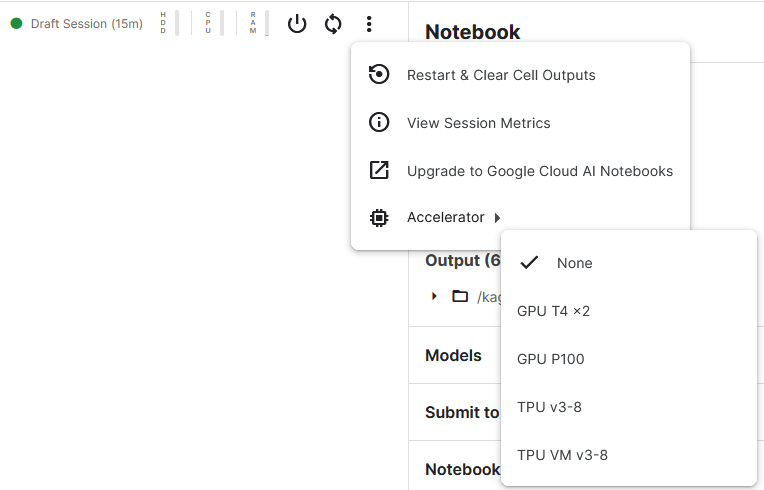

In [ ]:
# Library for Data science

import tensorflow as tf #NN processing
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import os
import PIL
import time

from IPython import display

In [ ]:
# Library for TPU acceleration
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

## Loading Data

The dataset we are using contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg.  
The monet_tfrec and monet_jpg directories contain the same painting images sized 256x256 in JPEG format or TFRecord format, and the photo_tfrec and photo_jpg directories contain the same photos also sized 256x256 in JPEG format or TFRecord format.  

The monet directories contain Monet paintings that we will use for training our models.  
The photo directories contain photos that we will add Monet-style and submit the new generated images.  

We want to keep our photo dataset and our Monet dataset separate. First, load in the filenames of the TFRecords.

In [ ]:
GCS_PATH = KaggleDatasets().get_gcs_path() #Get path of data from competition dataset

In [ ]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

In [ ]:
img_sz = 256
IMAGE_SIZE = [img_sz, img_sz]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

##### Define the function to extract the image from the files.



In [ ]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

Let's load in our datasets.

In [ ]:
batch_size = 32

In [ ]:
input_shape = tuple(IMAGE_SIZE) + (3,) #[256,256,3]
input_shape

In [ ]:
# batch_size: number of consecutive elements of this dataset to combine in a single batch --> batch_size=1 will give 1 element in each batch where we have a number of batch=number of elements in the dataset

# 288 allows to be a multiple of 32

if batch_size ==1 or batch_size ==12 :
    monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(batch_size)
    photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(batch_size)
else:
    monet_ds = load_dataset(MONET_FILENAMES, labeled=True).take(288).batch(batch_size)
    photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).take(288).batch(batch_size)

We took one exemple of each of theses lists.

In [ ]:
#next : Get following element of the iter(list) each time it is called. 
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

Let's visualize a photo example and a Monet example.

In [ ]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

In [ ]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    #print(str(i))
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    #ax[i, 1].imshow(monet)
    ax[i, 0].set_title("Input Photo")
    #ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()


Calcul of number of elements in datasets.

In [ ]:
len_monet_ds = 0
for i in monet_ds:
    #print(i)
    #print(len(i))
    len_monet_ds = len_monet_ds + len(i)
    #len_monet_ds+=1

In [ ]:
len_monet_ds #len_data = 

In [ ]:
len_photo_ds = 0
for i in photo_ds:
    #print(i)
    #len_photo_ds+=1
    len_photo_ds = len_photo_ds + len(i)
len_photo_ds

## 3. Model Preparation

In [ ]:
import os

In [ ]:
os.listdir('/kaggle/input')

In [ ]:
for path, directories, files in os.walk(os.getcwd()):
    for file in files:
        print("path:" + path)
        print('file:' + file)
        for file in files:
            file_name = os.path.join(path, file)
            print('file_name:' + file_name)

In [ ]:
path_model_dir_dataset = '/kaggle/input/p8-model-dataset'
gen_folder = os.path.join(path_model_dir_dataset,'training_model', "model_generator")
disc_folder = os.path.join(path_model_dir_dataset,'training_model', "model_discriminator")

In [ ]:
test_generator = tf.keras.models.load_model(gen_folder)
test_discriminator = tf.keras.models.load_model(disc_folder)

In [ ]:
# Exemple of generated images from a photo input passed through ou basic generator
noise_input = tf.random.normal([1, 100])

start = time.time()
to_monet = test_generator(noise_input)
print ('Time for one generated_image from photo is {} sec'.format(time.time()-start))

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

## 4.3. Buid the GAN

### 4.3.1. Define the loss and optimizers  

In this part, we'll focus more on the archhitecture of the GAN, and wich loss functions will be used.  
An detailed explanation of how the loss function was chosen can be found here: https://arxiv.org/pdf/1406.2661.pdf  
Let's build the loss functions:

In [ ]:
with strategy.scope():
    # This method returns a helper function to compute cross entropy loss
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)
    
    
    # we need to use reduction=tf.keras.losses.Reduction.NONE because of the use of strategy.scope()
    
    
    """
    ValueError: Please use `tf.keras.losses.Reduction.SUM` or `tf.keras.losses.Reduction.NONE` for loss reduction when losses are used with `tf.distribute.Strategy` outside of the built-in training loops. You can implement `tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE` using global batch size like:
    ```
    with strategy.scope():
        loss_obj = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    ....
        loss = tf.reduce_sum(loss_obj(labels, predictions)) * (1. / global_batch_size)
    ```
    Please see https://www.tensorflow.org/tutorials/distribute/custom_training for more details.
    """

# UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
#  '"`binary_crossentropy` received `from_logits=True`, but the `output`'
# --> If the discriminator end with sigmoid or softmax, the output will be between 0 to 1, or from_logits=True expect value from -inf to inf. If from_logits=False, values expected are from 0 to 1. That's why we could see an error.

In [ ]:
with strategy.scope():
    def discriminator_loss(real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

In [ ]:
with strategy.scope():
    def generator_loss(fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
with strategy.scope():
    generator_optimizer = tf.keras.optimizers.Adam(1e-4)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

We can test these functions:

In [ ]:
generator_loss(noise_to_monet)

In [ ]:
discriminator_loss(example_photo,noise_to_monet)

In [ ]:
(generator_loss(noise_to_monet) + discriminator_loss(example_photo,noise_to_monet)) /2

### 4.3.2. Save checkpoints

In [ ]:
# Some tools to save the model during training if an exception occured

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=test_generator,
                                 discriminator=test_discriminator)

In [ ]:
# Saving model directories

model_dir = './training_model'
gen_file = os.path.join(model_dir, "model_generator")
disc_file = os.path.join(model_dir, "model_discriminator")

In [ ]:
# Tools to save images during training and we'll be used for generating a GIF

def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        raw = int(np.around(num_examples_to_generate/5))
        col = 5
        
        plt.subplot(raw, col, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
        plt.axis('off')

    plt.savefig('img_epochs/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

### 4.3.3. Define training loop  

Here we will define the different training steps and loop to train our model.  
For better understanding, and because we think of using TPU, different ways to train our models will be implemented and tested.

In [ ]:
# Some inputs used for training loop
noise_dim = 100
num_examples_to_generate = 3
BATCH_SIZE = batch_size # Comme définit en entrée
#img_sz = 256

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate,noise_dim ])

In [ ]:
class GAN_class(tf.keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN_class, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        
    # Notice the use of `tf.function`
    # This annotation causes the function to be "compiled".
    @tf.function
    def train_step_to_distribute(self, images):
        noise = tf.random.normal([BATCH_SIZE, noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        # add codes to save losses
        #return [gen_loss, disc_loss]
        return (gen_loss + disc_loss)/2
    
    @tf.function
    def distributed_train_step(self, images):
        #images,generator,discriminator = dataset_inputs
        per_replica_losses = strategy.run(self.train_step_to_distribute, args=(images,))
        return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses,
                             axis=None)
    
    def train(self, dataset, epochs):
        gen_loss_list  = []
        disc_loss_list = []
        train_loss_list = []
        decision_list = []
        
        for epoch in range(epochs):
            start = time.time()

            total_loss = 0.0
            num_batches = 0
            for image_batch in dataset:
                loss = self.distributed_train_step(image_batch)
                total_loss += tf.reduce_mean(loss)
                num_batches += 1
                train_loss = total_loss / num_batches
                
            train_loss_list.append(train_loss)

                #[gen_loss, disc_loss] = train_step(image_batch,generator,discriminator)
                #gen_loss_list.append(gen_loss)
                #disc_loss_list.append(disc_loss)

            # Produce images for the GIF as you go
            display.clear_output(wait=True)
            generate_and_save_images(self.generator,
                                     epoch + 1,
                                     seed)

            # Save the model every 15 epochs
            #if (epoch + 1) % 15 == 0:
            #    checkpoint.save(file_prefix = checkpoint_prefix)

            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start)) # each line printed is overwritten. The last one is not visible # -> because of display.clear_output(wait=True)?


            # Evaluate the model
            #loss, acc = generator.evaluate(test_images, test_labels, verbose=2)
            #print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))


        # Generate after the final epoch
        display.clear_output(wait=True)
        generate_and_save_images(self.generator,
                               epochs,
                               seed)

        # Losses saved in lists
        #return gen_loss_list, disc_loss_list
        return train_loss_list
    

In [ ]:
class GAN_class_bis(tf.keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN_class_bis, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        
    def compile(self, generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss):
        super(GAN_class_bis, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss
        
    def train_step(self, images):
        
        noise = tf.random.normal([BATCH_SIZE, noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        # add codes to save losses
        #return [gen_loss, disc_loss]
        return {
            "gen_loss": gen_loss,
            "disc_loss": disc_loss,
            "decision":fake_output
            }
 

In [ ]:
class GAN_class_2(tf.keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN_class_2, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        
    def compile(self, generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss):
        super(GAN_class_2, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss
    
    #@tf.function
    def train_step(self, inputs):
        def step_fn(self, images):

            noise = tf.random.normal([BATCH_SIZE, noise_dim])

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_images = self.generator(noise, training=True)

                real_output = self.discriminator(images, training=True)
                fake_output = self.discriminator(generated_images, training=True)

                gen_loss = self.generator_loss(fake_output)
                disc_loss = self.discriminator_loss(real_output, fake_output)

            gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
            self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

            # add codes to save losses
            #return [gen_loss, disc_loss]
            return {
                "gen_loss": gen_loss,
                "disc_loss": disc_loss
                }
        per_replica_losses = strategy.run(step_fn, args=(inputs,))
        return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses,
                             axis=None)
        
        
        """
            @tf.function
    def distributed_train_step(self, images):
        #images,generator,discriminator = dataset_inputs
        per_replica_losses = strategy.run(self.train_step_to_distribute, args=(images,))
        return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses,
                             axis=None)
        """

# 5. Train the GAN

In [ ]:
EPOCHS = 120 #1200

make_submission = 0 # 0: no generation of images for submission, 1: generate images.zip for submission


# Choice of GAN strategy

iGAN = 1

# 0: monet_gan from GAN_class using distribute and train
# 1: monet_gan_bis from GAN_class_bis using compile and fit
# 2: monet_gan_2 from GAN_class_2 using compile and fit and distribute

In [ ]:
#with strategy.scope():
#[gen_loss_list, disc_loss_list] = train(monet_ds, EPOCHS,test_generator,test_discriminator)
#train_loss = train(monet_ds, EPOCHS,test_generator,test_discriminator)

In [ ]:
#len(gen_loss_list)

In [ ]:
#len(disc_loss_list)

In [ ]:
"""
fig = plt.figure(figsize =(10, 7))
plt.plot(gen_loss_list)
plt.plot(disc_loss_list)

plt.plot(np.mean(gen_loss_list),marker='o')
plt.plot(np.mean(disc_loss_list),marker='o')

plt.plot([0,100],[np.mean(gen_loss_list),np.mean(gen_loss_list)])
plt.plot([0,100],[np.mean(disc_loss_list),np.mean(disc_loss_list)])

plt.legend(['gen_loss_list','disc_loss_list',
           'mean_gen_loss_list','mean_disc_loss_list'])

plt.xlabel("Image number")
plt.ylabel("Generator and Discriminator losses")

plt.show()
"""

Restore latest checkpoint

In [ ]:
if iGAN ==0:
    import os
    os.mkdir("img_epochs")

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
if iGAN ==0:
    with strategy.scope():
        monet_gan = GAN_class(test_generator, test_discriminator)

In [ ]:
 #%debug
if iGAN ==0:
    #! mkdir img_epochs
    train_loss_result = monet_gan.train(monet_ds, EPOCHS)

In [ ]:
if iGAN ==0:
    fig = plt.figure(figsize =(10, 7))
    plt.plot(train_loss_result)

    plt.plot(np.mean(train_loss_result),marker='o')

    plt.plot([0,len(train_loss_result)],[np.mean(train_loss_result),np.mean(train_loss_result)])

    plt.legend(['train_loss_result','mean_train_loss_result'])

    plt.xlabel("Image number")
    plt.ylabel("Generator and Discriminator losses")

    plt.show()

In [ ]:
if iGAN ==1:
    with strategy.scope():
        test_generator_bis = pix_generator()
        test_discriminator_bis = pix_discriminator()
        monet_gan_bis = GAN_class_bis(test_generator_bis, test_discriminator_bis)
        monet_gan_bis.compile(generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss)

In [ ]:
#monet_gan_bis.generator.trainable_variables

In [ ]:
if iGAN ==1:
    history = monet_gan_bis.fit(monet_ds, epochs = EPOCHS)

In [ ]:
monet_gan_bis.generator(noise).shape[0]

In [ ]:
if iGAN ==1:
    fig = plt.figure(figsize =(10, 7))
    #plt.plot([0,len(history.history['gen_loss'])], history.history['gen_loss'])
    plt.plot(np.mean(history.history['gen_loss'], axis=1))
    plt.plot(np.mean(history.history['disc_loss'], axis=1))
    plt.plot(np.mean(history.history['decision'], axis=1))

    plt.plot(np.mean(np.mean(history.history['gen_loss'], axis=1)),marker='o')
    plt.plot(np.mean(np.mean(history.history['disc_loss'], axis=1)),marker='o')
    plt.plot(np.mean(np.mean(history.history['decision'], axis=1)),marker='o')

    plt.plot([0,len(np.mean(history.history['gen_loss'], axis=1))],[np.mean(np.mean(history.history['gen_loss'], axis=1)),np.mean(np.mean(history.history['gen_loss'], axis=1))])
    plt.plot([0,len(np.mean(history.history['disc_loss'], axis=1))],[np.mean(np.mean(history.history['disc_loss'], axis=1)),np.mean(np.mean(history.history['disc_loss'], axis=1))])
    plt.plot([0,len(np.mean(history.history['decision'], axis=1))],[np.mean(np.mean(history.history['decision'], axis=1)),np.mean(np.mean(history.history['decision'], axis=1))])


    plt.legend(['gen_loss','disc_loss','decision','mean_gen_loss','mean_disc_loss','mean_decision'])

    plt.xlabel("Image batch number")
    plt.ylabel("Generator and Discriminator losses")

    plt.show()

In [ ]:
if iGAN ==2:
    with strategy.scope():
        test_generator_2 = pix_generator()
        test_discriminator_2 = pix_discriminator()
        monet_gan_2 = GAN_class_2(test_generator_2, test_discriminator_2)
        monet_gan_2.compile(generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss)

In [ ]:
if iGAN ==2:
    monet_gan_2.fit(monet_ds, epochs = EPOCHS)

In [ ]:
# #Stop runing
#import sys
#sys.exit()

# 6. Test the GAN 

Création de GIF

In [ ]:
if iGAN ==0:
    # Display a single image using the epoch number
    def display_image(epoch_no):
        return PIL.Image.open('img_epochs/image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
if iGAN ==0:
    display_image(EPOCHS)

In [ ]:
if iGAN == 0:
    generator_to_test = monet_gan.generator
elif iGAN == 1:
    generator_to_test = monet_gan_bis.generator
elif iGAN == 2:
    generator_to_test = monet_gan_2.generator


fig = plt.figure(figsize=(10, 10))

#num_examples_to_generate = 10
for i in range(generator_to_test(seed).shape[0]):
    raw = int(np.around(num_examples_to_generate/5))
    col = 5

    plt.subplot(raw, col, i+1)
    plt.imshow(generator_to_test(seed)[i, :, :, 0] * 127.5 + 127.5)
    plt.axis('off')

## Animated Gif

In [ ]:
if iGAN ==0:
    import imageio.v2 as imageio

    anim_file = 'dcgan.gif'

    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob('img_epochs/image*.png')
        filenames = sorted(filenames)
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

In [ ]:
if iGAN ==0:
    # To generate GIFs
    ! pip install imageio
    ! pip install git+https://github.com/tensorflow/docs

In [ ]:
if iGAN ==0:
    import tensorflow_docs.vis.embed as embed
    embed.embed_file(anim_file)

# 7. Save model

In [ ]:
# Saving model

model_dir = './training_model'
gen_file = os.path.join(model_dir, "model_generator")
disc_file = os.path.join(model_dir, "model_discriminator")

In [ ]:
# Methods for saving the generated folder of saved trained model in a file that we can easily download in kaggle
from zipfile import ZipFile
import os

def save_model_zip(test_folder,zip_file):

    #zip_file = "test_folder.zip"  # zip file name
    directory = test_folder

    with ZipFile(zip_file, 'w') as zip_obj:
        for path, directories, files in os.walk(directory):
            for file in files:
                file_name = os.path.join(path, file)

                zip_obj.write(file_name) # zipping the file

    print("Contents of the zip file:")
    with ZipFile(zip_file, 'r') as zip_obj:
        zip_obj.printdir()

In [ ]:
# Saving actions if using CPU/GPU
"""   
monet_gan.generator.save(gen_file) # + str(epoch))
monet_gan.discriminator.save(disc_file) # + str(epoch))

zip_file = os.path.join(model_dir, "gan_model_file.zip")
#save_model_zip(gen_file,zip_file)
#save_model_zip(disc_file,zip_file) # cet enregistrement écrase le précédent
save_model_zip(model_dir,zip_file)"""

#from IPython.display import FileLink
#FileLink(gen_file)
#FileLink(disc_file)

In [ ]:
# Saving actions if using TPU

save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')

if iGAN ==0:
    monet_gan.generator.save(gen_file, options=save_locally) # + str(epoch))
    monet_gan.discriminator.save(disc_file, options=save_locally) 
elif iGAN ==1:
    monet_gan_bis.generator.save(gen_file, options=save_locally) # + str(epoch))
    monet_gan_bis.discriminator.save(disc_file, options=save_locally) 
elif iGAN ==2:
    monet_gan_2.generator.save(gen_file, options=save_locally) # + str(epoch))
    monet_gan_2.discriminator.save(disc_file, options=save_locally)     
    
zip_file = os.path.join(model_dir, "gan_model_file.zip")
#save_model_zip(gen_file,zip_file)
#save_model_zip(disc_file,zip_file) # cet enregistrement écrase le précédent
save_model_zip(model_dir,zip_file)

# 8. Create submission file

In [ ]:
if make_submission == 1:
    ! mkdir ../images

In [ ]:
if make_submission == 1:
    i = 1
    nb_img2gen = 7000
    for img in range(nb_img2gen):
        noise = tf.random.normal([1, 100])

        if iGAN ==0:
            prediction = monet_gan.generator(noise, training=False)[0].numpy()
        elif iGAN ==1:
            prediction = monet_gan_bis.generator(noise, training=False)[0].numpy()
        elif iGAN ==2:
            prediction = monet_gan_2.generator(noise, training=False)[0].numpy()

        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        im = PIL.Image.fromarray(prediction)
        im.save("../images/" + str(i) + ".jpg")
        i += 1

In [ ]:
if make_submission == 1:
    import shutil
    shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")